In [1]:

# Import all modules to run the following scripts


import os
import copy
import math
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import cdist
import scipy.stats as ss
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as CD
from IPython.display import SVG
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [2]:

# This block will read in all data calculated for the chosen dataset and compile it in a dictionary called "plot_data"

plot_data = {}

with open("BA_featurization_data.csv", "r") as f:
    raw = f.readlines()

properties = raw.pop(0).rstrip("\n").split(",")

for i, line in enumerate(raw):

    plot_data[i] = {}

    values = line.rstrip("\n").split(",")

    for j, value in enumerate(values):
        
        try:
            plot_data[i][properties[j]] = float(value)
        except:
            plot_data[i][properties[j]] = value


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


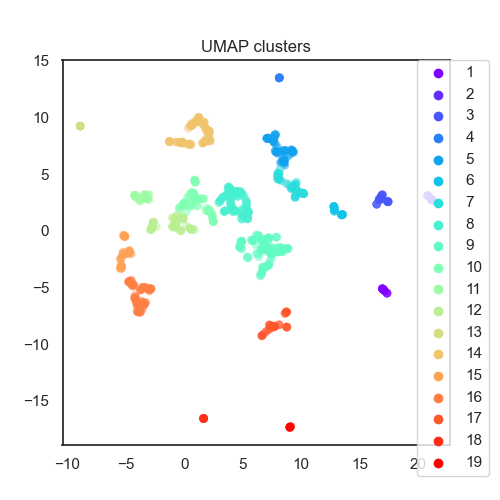

In [3]:

# This block will use the "plot_data" dictionary and run the UMAP algorithm for the properties defined in the "umap_data" object for all dimension-, nearest_neighbor-, and seed values. 
# It will then use silhouette scores to determine the highest scoring UMAP/Nr of clusters combination. It then assigns molecules to clusters and finally plots the result.

%matplotlib widget

column_titles = list(plot_data[0].keys())
a = pd.DataFrame.from_dict(plot_data, orient="index", columns=column_titles)

# YOU CAN CHANGE THESE VALUES
dims = [2]
ns = [int(math.sqrt(a.shape[1]))]
seeds = list(range(0, 2))
#--------------------------------------

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


# YOU CAN CHANGE THESE VALUES BY (UN)COMMENTING
umap_data = a[
    [
        "E NEG",
        "HARDNESS",
        "SOFTNESS",
        "DIPOLE",
        "LOEWDIN",
        "MULLIKEN",
        "HIRSHFELD",
        "HOMO",
        "LUMO",
        "FSPE",
        #"MAYER",
        "CB DIST",
        "CHEM SHIELD",
        "Vbur",
        "ADCH",
        "MK-ESP",
        "CM5",
        "QTAIM",
        "IBO",
        #"MolWeight"
    ]
].values
scaled_data = StandardScaler().fit_transform(umap_data)
#--------------------------------------

embeddings = {}

for dim in dims:
    embeddings[dim] = {}
    for n in ns:
        embeddings[dim][n] = {}
        for seed in seeds:
            embeddings[dim][n][seed] = {}
            embeddings[dim][n][seed]["umap"] = UMAP(n_neighbors = n, n_components = dim, random_state = seed, min_dist=0.1, spread=1.0).fit_transform(scaled_data)

tmp = {
    "scores": [],
    "dims": [],
    "ns": [],
    "seeds": [],
    "clusters": [],
}

N_CLS_list = list(range(10, 30)) #+ list(range(22, 48)) + list(range(50, 100)) + list(range(110, 200))


def silhouette_scores_hierarchical(data, n_cls_list):
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

silh_scores = pd.DataFrame(index=N_CLS_list, dtype=float)
#fig = plt.figure()

all_time_best = 0
lowest_of_best = 1

for dim in embeddings.keys():
    for n in embeddings[dim].keys():
        for seed in embeddings[dim][n].keys():
            best_score = 0.0
            best_n = -1
            score = silhouette_scores_hierarchical(embeddings[dim][n][seed]["umap"], N_CLS_list)
            #name = f"{dim}d_{n}n_{seed}s"
            #silh_scores[name] = score
            #score.plot(xlabel='number of clusters',ylabel='silhouette score')
            for s, value in enumerate(score):
                if value >= best_score:
                    best_score = value
                    best_n = s + N_CLS_list[0]

                    embeddings[dim][n][seed]["score"] = best_score
                    embeddings[dim][n][seed]["best_n"] = best_n



            if best_score > all_time_best:
                all_time_best = best_score

            if best_score < lowest_of_best:
                lowest_of_best = best_score
                
            tmp["scores"].append(best_score)
            tmp["dims"].append(dim)
            tmp["ns"].append(n)
            tmp["seeds"].append(seed)
            tmp["clusters"].append(best_n)

for i, value in enumerate(tmp["scores"]):
    tmp["scores"][i] = (value - lowest_of_best)/(all_time_best - lowest_of_best)

df = pd.DataFrame.from_dict(tmp)

for row in df.iterrows():
    if row[1]["scores"] == 1.0:
        opt_dimensions = row[1]["dims"]
        opt_neighbors = row[1]["ns"]
        opt_seed = row[1]["seeds"]
        opt_embedding = embeddings[opt_dimensions][opt_neighbors][opt_seed]["umap"]
        NCLS = int(row[1]["clusters"])
                   

sns.set(style = "white")

# linkage and clustering for selected featurization
z = linkage(opt_embedding, method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot the dendrogram
#plt.figure(figsize=(5, 5))
#_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True,leaf_rotation=90, color_threshold=0)


# plot clustering
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

sns.scatterplot(x=opt_embedding[:,0], y=opt_embedding[:,1], s=35, alpha=0.5, linewidth=0.25, edgecolor='face',palette='rainbow', legend='full', hue=cls, ax = ax1, markers="+").set_title("UMAP clusters")
_=plt.legend(bbox_to_anchor=(1.1, 1), loc=1, borderaxespad=0.)



Molecule 491, Smile CCCCC[C@H]1CC[C@@H](CC1)C1=CC=C(C=C1)B(O)O


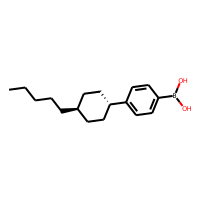

Molecule 119, Smile CC(C)(C)[Si](C)(C)OC1=CC=C(C=C1)B(O)O


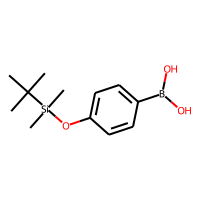

Molecule 60, Smile COC(=O)C1=CC(=CC=C1)B(O)O


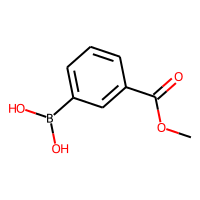

Molecule 594, Smile OB(O)C1=CC=C(C=C1)C(=O)N1CCC1


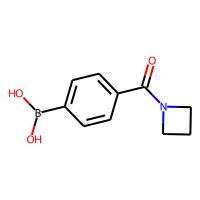

Molecule 237, Smile OB(O)C1=C(I)C=CC=C1


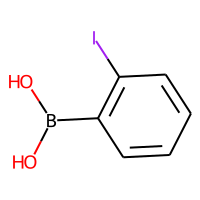

Molecule 258, Smile OB(O)C1=CC=C(C=C1)C(=O)OCC1=CC=CC=C1


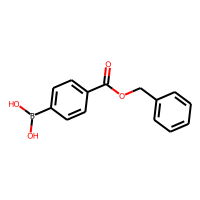

Molecule 383, Smile COC1=CC(B(O)O)=C(Cl)C=N1


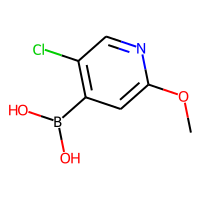

Molecule 44, Smile OB(O)C1=CN=CN=C1


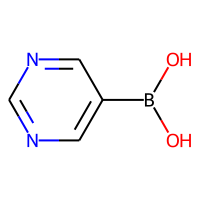

Molecule 182, Smile CC1=CSC(=C1)B(O)O


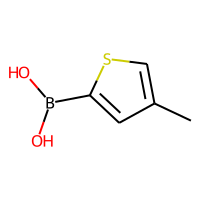

Molecule 47, Smile OB(O)C1=CC(Br)=CC=C1


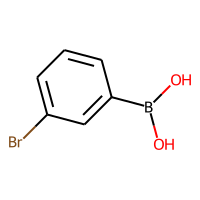

Molecule 40, Smile OB(O)C1=CC2=C(O1)C=CC=C2


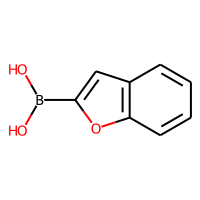

Molecule 275, Smile COCCOC1=CC=C(C=C1)B(O)O


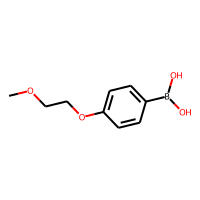

Molecule 432, Smile COC1=CC2=C(SC(=C2)B(O)O)C=C1


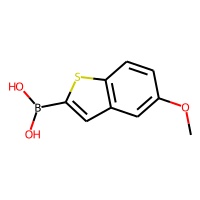

Molecule 229, Smile OB(O)C1=CC=C(Br)S1


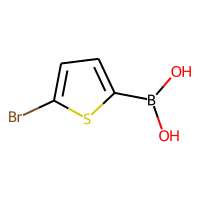

Molecule 680, Smile OB(O)C1=C(COC2CCCCC2)C=CC=C1


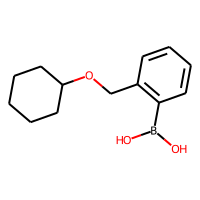

Molecule 617, Smile CC(C)CN1N=CC=C1B(O)O


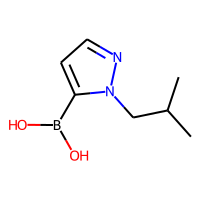

Molecule 85, Smile OB(O)C1=NC=CC=C1


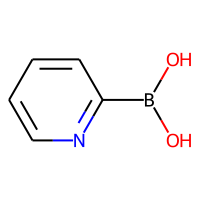

Molecule 338, Smile CC(C)(C)OC(=O)N1C(=CC2=C1C=CC(=C2)C#N)B(O)O


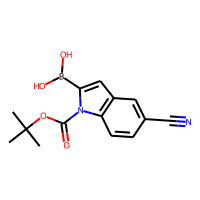

Molecule 500, Smile CC(=O)C1=CC=C(C=C1)C1=CC=C(C=C1)B(O)O


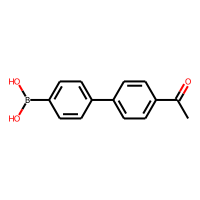

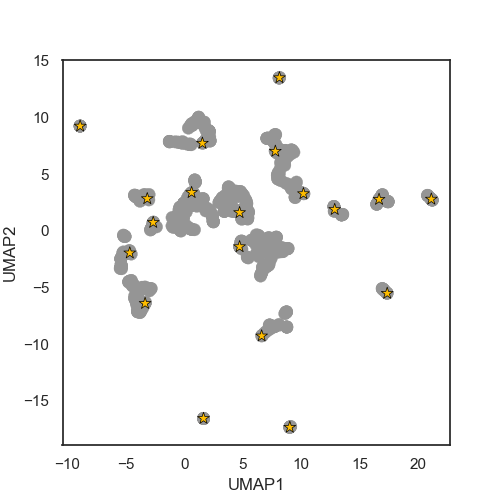

In [6]:
# This block will pick a random molecule from each cluster and plot the final results with respect to the chemical space and molecular structure.

# Create a dictionary with cluster-# as keys, populated with the respective compound indeces

clusters = {}
for key in plot_data.keys():
    if cls[key] not in clusters.keys():
        clusters[cls[key]] = []
    clusters[cls[key]].append(key)


# Pick a random boronic acid index from each cluster and save it

from random import randrange

index_groups = {}
index_groups["cat1"] = []

for key in clusters.keys():
    index_groups["cat1"].append(clusters[key][randrange(len(clusters[key])-1)])

# Find the randomly picked molecules in the "opt_embedding" to be able to mark them in the chemical space

def get_partial_data(embedding, dict):

    first_elem = 1

    for key in dict.keys():
        indices = dict[key]
        markers.append("*")
        for index in indices:
            elem = [embedding[index][0], embedding[index][1]]

            if first_elem == 1:
                temp = np.array([elem])
                group = np.array([key])
                ind = np.array([index])
                first_elem = 0
            
            else:    
                temp = np.append(temp, [elem], axis = 0)
                group = np.append(group, [key], axis = 0)
                ind = np.append(ind, [index], axis = 0)

    return [temp, group, ind]


lowest_cat_for_clusters = [3] * NCLS

for i, value in enumerate(opt_embedding):
    for index, key in enumerate(index_groups.keys()):
        for entry in index_groups[key]:
            if i == entry:
                if index < lowest_cat_for_clusters[cls[i]-1]:
                    lowest_cat_for_clusters[cls[i]-1] = index

grp = []
for i, value in enumerate(cls):
    grp.append(lowest_cat_for_clusters[value-1])

markers = []
data = get_partial_data(opt_embedding, index_groups)
coords = pd.DataFrame(data[0], columns=["UMAP1", "UMAP2"])
groups = data[1]
opt_e = pd.DataFrame(opt_embedding, columns=["UMAP1", "UMAP2"])
simple_group = [1] * len(groups)


# Plot the chemical space and the randomly picked molecules as stars

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

sns.scatterplot(data = opt_e, x = "UMAP1", y = "UMAP2", s = 80, alpha = 1, linewidth = 0.25, edgecolor = 'face', palette = "Greys", hue=1, ax = ax1)
sns.scatterplot(data = coords, x = "UMAP1", y = "UMAP2", s = 80, alpha = 1, linewidth = 0.5, edgecolor = 'black', palette = "Wistia", markers=markers, style=groups, ax=ax1, hue=simple_group)

ax1.get_legend().remove()


# Plot the randomly picked molecules

for i, entry in enumerate(index_groups["cat1"]):
    print (f"Molecule {entry}, Smile {plot_data[entry]['SMILES']}")
    mol = [Chem.MolFromSmiles(plot_data[entry]["SMILES"])]
    ms = mol
    pic = Chem.Draw.MolsToGridImage(ms, molsPerRow=1, returnPNG = False)
    display(pic)


#entry = index_groups["cat1"][2]
#ms = [Chem.MolFromSmiles(plot_data[entry]["SMILES"])]
#pic = Chem.Draw.MolsToGridImage(ms, molsPerRow=1, returnPNG = False)
#display(pic)

